This notebook simulates the continuous measurement of a three-qubit quantum system using the stochastic master equation (SME) and applies Chebyshev filtering to enhance the fidelity of logical states. It explores the effects of different Chebyshev polynomial degrees and amplitudes on the fidelity of the logical states |0_L⟩ and |1_L⟩, comparing results with exponential filtering.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

In [17]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']

    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')

    print(f"|ψ⟩ = {superposition_str}")

In [18]:
# Parameters
gamma_m = 1  # Measurement strength
T_max = 500 / gamma_m
dt = 0.01 / gamma_m  # Time step
times = np.arange(0, T_max, dt)
sigma = 50 / gamma_m  # Pulse width
omega_max = 1
eta = 1.0  # Quantum efficiency
tau = 2.5 / gamma_m  # Measurement time parameter

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)
X1, X2, X3 = [tensor([X if i == k else I for i in range(3)]) for k in range(3)]
Z1, Z2, Z3 = [tensor([Z if i == k else I for i in range(3)]) for k in range(3)]
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3
I_L = tensor(I, I, I)

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))

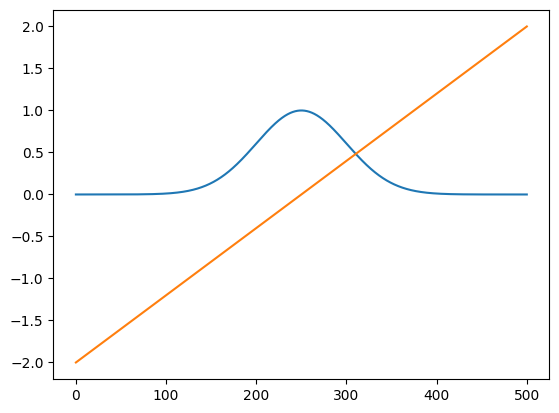

In [19]:
plt.plot(times, omega_t(times))
plt.plot(times, delta_t(times))
plt.show()

only population invertion while continuously measuring H — without filtering

0.0027425356479116587 0.9972574643520883


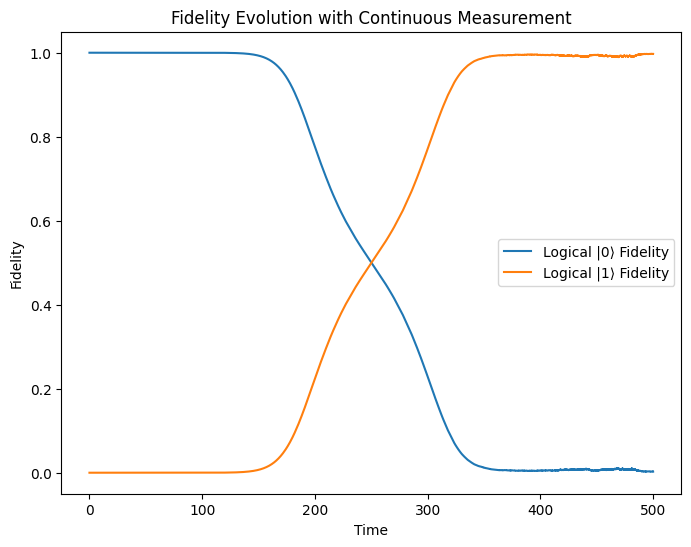

In [20]:
# Initial state: logical |0_L>
psi0 = zero
rho = ket2dm(psi0)

# Measurement signals
I_Hs = []

# Record fidelities
fidelities_0 = []
fidelities_1 = []


expects = []

# Time evolution loop
for t in times:
    # Hamiltonian - RAP
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()


    # Measurement current (with noise)
    I_H = expect(H, rho)
    # I_H = expect(H, rho)
    I_Hs.append(I_H)

    # Record fidelities
    fidelities_0.append(np.abs((zero.dag() * rho * zero)))
    fidelities_1.append(np.abs((one.dag() * rho * one)))
    expects.append(I_H)

print(fidelities_0[-1], fidelities_1[-1])
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(times, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(times, fidelities_1, label='Logical |1⟩ Fidelity')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Continuous Measurement")
plt.legend()
plt.show()

8.874590248310968e-13 0.9999999999991126


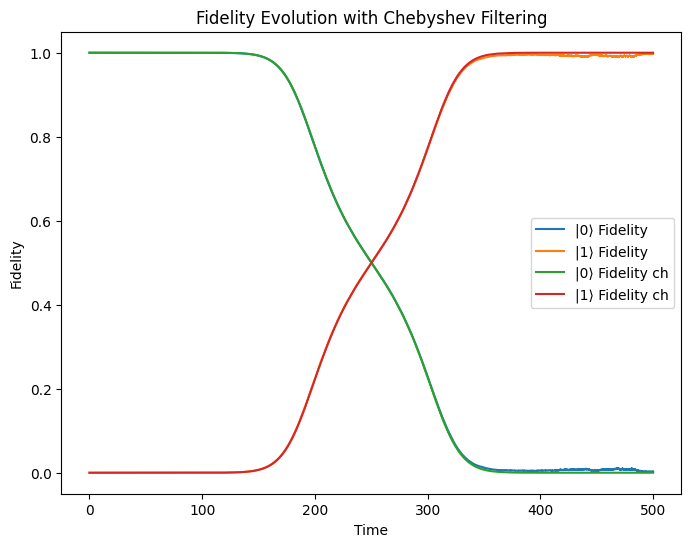

/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


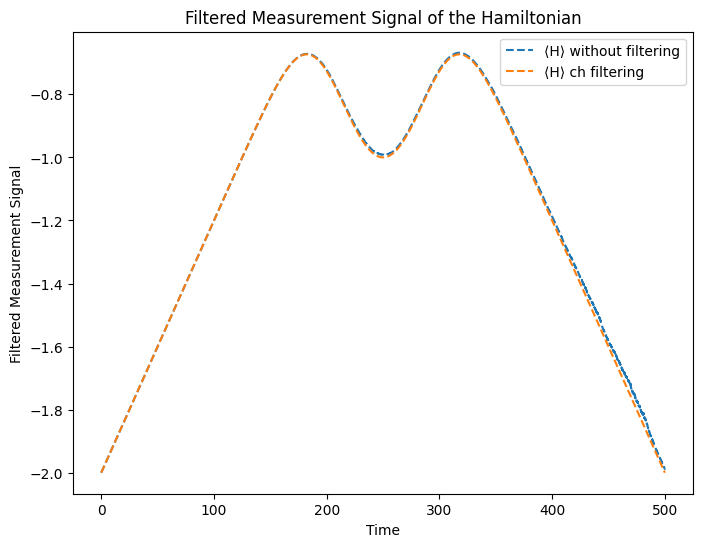

In [21]:
# Chebyshev filtering parameters
cheb_degree = 1
cheb_a = 0.01

def rescale_H(H):
    evals = H.eigenenergies()
    E_min, E_max = np.min(evals), np.max(evals)
    return (-2 * omega_max * H - (E_max + E_min) * I_L) / (E_max - E_min)

def chebyshev_filter(rho, H_rescaled, degree=cheb_degree, a=cheb_a):
    T0 = rho
    T1 = H_rescaled * rho
    filtered = T0 + 2 * np.exp(-a * 1) * T1

    for n in range(2, degree):
        Tn = 2 * H_rescaled * T1 - T0
        coeff = 2 * np.exp(-a * n)
        filtered += coeff * Tn
        T0, T1 = T1, Tn

    # Normalize trace to 1
    return filtered.unit()


# Measurement signals
I_H_bar = -2 * omega_max
I_Hs = []

# Record fidelities
fidelities_0_ch = []
fidelities_1_ch = []

# Target logical states
zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one = tensor(basis(2, 1), basis(2, 1), basis(2, 1))
rho = ket2dm(zero)
expects_ch = []

plt.figure(figsize=(8, 6))

# Time evolution loop
for i, t in enumerate(times):
    # Hamiltonian
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Continuous measurement of the Hamiltonian
    dW = np.random.normal(scale=np.sqrt(dt))
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    # Update density matrix
    drho = -1j * (H * rho - rho * H)
    drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
    drho += meas_H * dW
    rho = (rho + dt * drho).unit()

    # Apply Chebyshev filtering every few steps
    if i % 100 == 0:  # Apply filtering every 10 steps
        # if i == 0:
        #     pass
        # else:
        # plt.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
        H_rescaled = rescale_H(H)
        rho = chebyshev_filter(rho, H_rescaled)

    # Measurement current (with noise)
    # I_H = expect(H, rho)
    I_H = expect(H, rho)

    # I_Hs.append(I_H_bar)
    I_Hs.append(I_H)

    # Record fidelities
    fidelities_0_ch.append(np.abs((zero.dag() * rho * zero)))
    fidelities_1_ch.append(np.abs((one.dag() * rho * one)))
    expects_ch.append(I_H)

print(fidelities_0_ch[-1], fidelities_1_ch[-1])

# Plot results
plt.plot(times, fidelities_0, label='|0⟩ Fidelity')
plt.plot(times, fidelities_1, label='|1⟩ Fidelity')
plt.plot(times, fidelities_0_ch, label='|0⟩ Fidelity ch')
plt.plot(times, fidelities_1_ch, label='|1⟩ Fidelity ch')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Chebyshev Filtering")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(times, expects, label='⟨H⟩ without filtering', linestyle='--')
plt.plot(times, expects_ch, label='⟨H⟩ ch filtering', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Filtered Measurement Signal")
plt.title("Filtered Measurement Signal of the Hamiltonian")
plt.legend()
plt.show()

In [22]:
# Parameter ranges
cheb_degrees = [1, 10, 20, 30, 40, 50, 70]
cheb_as = [0.01, 0.1, 1, 2, 5, 10, 20]

# Store results
results = {}

# Loop over parameter combinations
for degree in tqdm(cheb_degrees, "Chebyshev Degree"):
    for a in tqdm(cheb_as, "Chebyshev Amplitude"):
        rho = ket2dm(psi0)
        fidelities_0 = []

        for i, t in enumerate(times):
            # Hamiltonian
            H = omega_t(t) * X_L + delta_t(t) * Z_L

            # Continuous measurement of the Hamiltonian
            dW = np.random.normal(scale=np.sqrt(dt))
            meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

            # Update density matrix
            drho = -1j * (H * rho - rho * H)
            drho += gamma_m * (H * rho * H - 0.5 * (H**2 * rho + rho * H**2))
            drho += meas_H * dW
            rho = (rho + dt * drho).unit()

            # Apply Chebyshev filtering every few steps
            if i % 10 == 0:
                H_rescaled = rescale_H(H)
                rho = chebyshev_filter(rho, H_rescaled, degree, a)

            # Record fidelity
            fidelities_0.append(np.abs((zero.dag() * rho * zero)))

        # Store final fidelity
        results[(degree, a)] = fidelities_0[-1]

# Find the best parameters
best_params = min(results, key=results.get)
best_fidelity = results[best_params]

print(f"Best parameters: cheb_degree = {best_params[0]}, cheb_a = {best_params[1]}")
print(f"Best fidelity: {best_fidelity}")

Chebyshev Degree: 100%|██████████| 7/7 [04:40<00:00, 40.13s/it]

Best parameters: cheb_degree = 1, cheb_a = 0.01
Best fidelity: 8.826927846310454e-13


# Conpare with exponential filtering